In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import GPy
from dipy.core.gradients import gradient_table
from diGP.preprocessing_pipelines import get_SPARC_train_and_test
from diGP.dataManipulations import (DataHandler, log_q_squared)
from diGP.model import Model

%matplotlib inline
sns.set_style('dark')

In [4]:
dataPath = {'SPARC_20': 'C:\\Users\\sesjojen\\Documents\\Data\\SPARC\\nifti\\gradient_20_nifti',
            'SPARC_30': 'C:\\Users\\sesjojen\\Documents\\Data\\SPARC\\nifti\\gradient_30_nifti',
            'SPARC_60': 'C:\\Users\\sesjojen\\Documents\\Data\\SPARC\\nifti\\gradient_60_nifti',
            'SPARC_GS': 'C:\\Users\\sesjojen\\Documents\\Data\\SPARC\\nifti\\goldstandard_nifti'}
q_test_path = 'C:\\Users\\sesjojen\\Documents\\Data\\SPARC\\EstimatedSignal_qvec.txt'

Load data to use for prediction.

In [5]:
source = 'SPARC_20'
gtab, data, voxelSize = get_SPARC_train_and_test(dataPath[source], dataPath['SPARC_GS'], q_test_path)

Loading SPARC data located at C:\Users\sesjojen\Documents\Data\SPARC\nifti\gradient_20_nifti
Checking for negative data.
Extracting b0 image.
Creating mask.
Normalizing data.
Loading SPARC data located at C:\Users\sesjojen\Documents\Data\SPARC\nifti\goldstandard_nifti
Checking for negative data.
Extracting b0 image.
Creating mask.
Normalizing data.


In [6]:
lmbda=None
handler = DataHandler(gtab['train'], data['train'], qMagnitudeTransform=log_q_squared,
                      voxelSize=voxelSize[0:2], box_cox_lambda=lmbda)
handlerPred = DataHandler(gtab['test'], data=None, spatial_shape=data['test'].shape[0:2],
                          qMagnitudeTransform=log_q_squared, voxelSize=voxelSize[0:2], box_cox_lambda=lmbda)


In [7]:
spatialLengthScale = 5
bValLengthScale = 3

kernel = (GPy.kern.RBF(input_dim=1, active_dims=[0],
                       variance=1,
                       lengthscale=spatialLengthScale) *
          GPy.kern.RBF(input_dim=1, active_dims=[1],
                       variance=1,
                       lengthscale=spatialLengthScale) *
          GPy.kern.RBF(input_dim=1, active_dims=[2],
                            variance=1,
                            lengthscale=bValLengthScale) *
          GPy.kern.LegendrePolynomial(
             input_dim=3,
             coefficients=np.array((2, 0.5, 0.05)),
             orders=(0, 2, 4),
             active_dims=(3, 4, 5)))

kernel.parts[0].variance.fix(value=1)
kernel.parts[1].variance.fix(value=1)
kernel.parts[2].variance.fix(value=1)

grid_dims = [[0], [1], [2, 3, 4, 5]]

model = Model(handler, kernel, data_handler_pred=handlerPred, grid_dims=grid_dims, verbose=False)

In [8]:
np.random.seed(0)
model.train(restarts=True)

print(model.GP_model)
print("\nLegendre coefficients: \n{}".format(model.GP_model.mul.LegendrePolynomial.coefficients))

Optimization restart 1/10, f = -11703.020902644445
Optimization restart 2/10, f = -11703.020903040238
Optimization restart 3/10, f = -11703.020901576352
Optimization restart 4/10, f = -11703.020900388861
Optimization restart 5/10, f = 190892859047.0241
Optimization restart 6/10, f = -11703.020902940227
Optimization restart 7/10, f = -11703.0209019068
Optimization restart 8/10, f = -11067.041294604418
Optimization restart 9/10, f = -10653.224799907037
Optimization restart 10/10, f = -11703.02089990263

Name : GP Grid regression
Objective : -11703.020903040238
Number of Parameters : 10
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_Grid_regression.                  |             value  |  constraints  |  priors
  mul.rbf.variance                     |               1.0  |   fixed +ve   |        
  mul.rbf.lengthscale                  |     2.38410555151  |      +ve      |        
  mul.rbf_1.variance                   |               1.0  |   fixed +ve   |        


In [9]:
mu = model.predict(compute_var=False)

pred = {'GP': model.data_handler_pred.untransform(mu)}

## Reference prediction with dipy

In [10]:
import dipy.reconst.dti as dti

tenmodel = dti.TensorModel(gtab['train'])
tenfit = tenmodel.fit(data['train'])

pred['DTI'] = tenfit.predict(gtab['test'])

In [14]:
import dipy.reconst.mapmri as mapmri

map_model = mapmri.MapmriModel(gtab['train'], positivity_constraint=False)
mapfit = map_model.fit(data['train'])

pred['MAP'] = mapfit.predict(gtab['test'])

## Evaluation

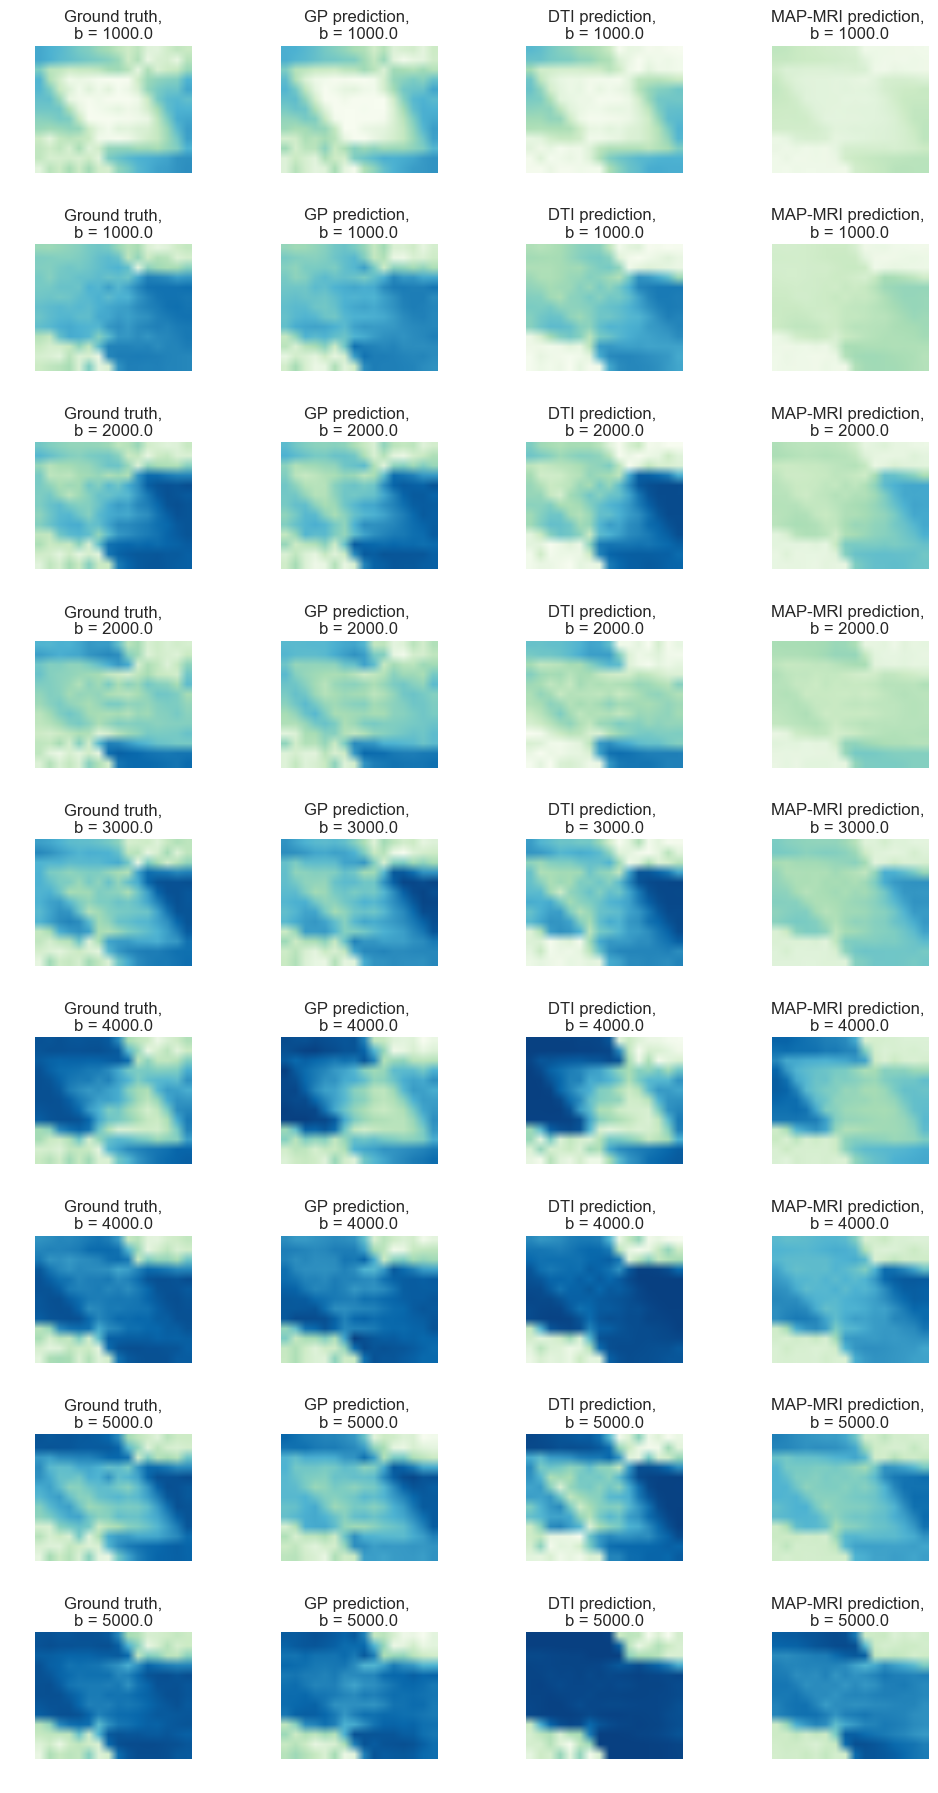

In [16]:
idx = 50 * np.arange(9)
f, axs = plt.subplots(len(idx), 4)
f.set_figheight(len(idx)*2)
f.set_figwidth(10)
for i, index in enumerate(idx):
    axs[i, 0].imshow(data['test'][:, :, index], vmin=0, vmax=1, cmap="GnBu_r")
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Ground truth,\nb = {}'.format(np.round(gtab['test'].bvals[index])))
    axs[i, 1].imshow(pred['GP'][:, :, index], vmin=0, vmax=1, cmap="GnBu_r")
    axs[i, 1].axis('off')
    axs[i, 1].set_title('GP prediction, \nb = {}'.format(np.round(gtab['test'].bvals[index])))
    axs[i, 2].imshow(pred['DTI'][:, :, index], vmin=0, vmax=1, cmap="GnBu_r")
    axs[i, 2].axis('off')
    axs[i, 2].set_title('DTI prediction, \nb = {}'.format(np.round(gtab['test'].bvals[index])))
    axs[i, 3].imshow(pred['MAP'][:, :, index], vmin=0, vmax=1, cmap="GnBu_r")
    axs[i, 3].axis('off')
    axs[i, 3].set_title('MAP-MRI prediction, \nb = {}'.format(np.round(gtab['test'].bvals[index])))

plt.tight_layout()

In [17]:
def get_SPARC_metrics(gtab, target, pred):
    bvals_in_range = (gtab.bvals <= 3500)  # 3500 instead of 3000 just to avoid round-off problems
    lowIdx = np.nonzero(bvals_in_range)
    highIdx = np.nonzero(np.invert(bvals_in_range))
    NMSE_low = compute_NMSE(target[:, :, lowIdx], pred[:, :, lowIdx])
    NMSE_high = compute_NMSE(target[:, :, highIdx], pred[:, :, highIdx])
    NMSE_all = compute_NMSE(target, pred)
    print("NMSE low: {}\nNMSE high: {}\nNMSE all: {}".format(NMSE_low, NMSE_high, NMSE_all))
    return NMSE_low, NMSE_high, NMSE_all

def compute_NMSE(target, pred):
    target = target.flatten()
    pred = pred.flatten()
    return np.mean(((target - pred)/target) **2)

for key, value in pred.items():
    print("\n{} model:".format(key))
    get_SPARC_metrics(gtab['test'], data['test'], value)


MAP model:
NMSE low: 1.9553695522822798
NMSE high: 1.1964137760239286
NMSE all: 1.6517872417789394

GP model:
NMSE low: 0.03452658536593252
NMSE high: 0.250070456822633
NMSE all: 0.1207441339486127

DTI model:
NMSE low: 0.07865178619130589
NMSE high: 0.24003453733688107
NMSE all: 0.14320488664953593
